# Data Exploration

## import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('baseline')

In [2]:
def json_to_df(json_file=None):
    """ Reads a single JSON file containing the
    shipment information and converts it to a
    structured dataframe
    """
    import pandas as pd
    from pandas.io.json import json_normalize
    import numpy as np
    logger.debug("Converting to dataframe: {}".format(json_file))
    df = pd.read_json(json_file, dtype={"shipment_number": str})
    normalized_df = json_normalize(df['events'])
    df.drop(["events"], axis=1, inplace=True)
    df = pd.concat([df, normalized_df], axis=1)
    if "Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen." == df.tail(1)["status"].item():
        logger.warning("Final delivery state is strange! Ignoring the file {}".format(json_file))
        return
    # Some files have multiple states. It does not make sense!
    if df[df["status"] == "Die Sendung wurde erfolgreich zugestellt."].shape[0] > 1:
        logger.warning("Multiple final states! Ignoring the file {}".format(json_file))
        return
    if df["status"].isnull().any():
        logger.warning("Status column has missing values! Ignoring the file {}".format(json_file))
        return
    if len(df["url"].unique()) > 1:
        logger.warning("Multiple URLs for a single shipment number! Something is wrong")
    if len(df["shipment_number"].unique()) > 1:
        logger.warning("Multiple shipment numbers in the same file. Something is wrong")
    df['crawltime'] = pd.to_datetime(df['crawltime'], utc=True)
    df['datum'] = pd.to_datetime(df['datum'], utc=True)
    if df["status"].isnull().values.any():
        logger.warning("Column status has missing values! ShipmentNumber: {}".format(df["shipment_number"].values[0]))
    final_event_array = np.zeros(len(df))
    final_event_array[-1] = 1
    df["is_final_event"] = final_event_array
    return df

In [5]:
def files_to_df(path='../data', n=None):
    """ Convert all files to a single dataframe
    """
    import os
    import pandas as pd
    files = []
    counter = 0
    for r, d, f in os.walk(path):
        for file in f:
            if counter > n:
                break
            counter = counter + 1
            if '.json' in file:
                files.append(os.path.join(r, file))
    dfs = [json_to_df(json_file=file) for file in files]
    df = pd.concat(dfs, sort=False)
    return df

In [6]:
df = files_to_df(path='../data', n=100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  # This is added back by InteractiveShellApp.init_path()


In [10]:
print(df.head().to_latex(escape=False))

\begin{tabular}{lllllllr}
\toprule
{} &       shipment_number &                 crawltime &                                                url &                     datum &                                             status &       ort &  is_final_event \\
\midrule
0 &  00340434188193325701 & 2020-01-05 21:24:49+00:00 &  https://www.dhl.de/int-verfolgen/search?langua... & 2019-10-08 14:42:00+00:00 &  Die Sendung wurde elektronisch angeku00FCndigt... &       NaN &             0.0 \\
1 &  00340434188193325701 & 2020-01-05 21:24:49+00:00 &  https://www.dhl.de/int-verfolgen/search?langua... & 2019-10-08 18:19:00+00:00 &  Die Sendung wurde von DHL bearbeitet und wird ... &   Hamburg &             0.0 \\
2 &  00340434188193325701 & 2020-01-05 21:24:49+00:00 &  https://www.dhl.de/int-verfolgen/search?langua... & 2019-10-09 02:44:00+00:00 &  Die Sendung ist in der Region des Empfu00E4nge... &  Saulheim &             0.0 \\
3 &  00340434188193325701 & 2020-01-05 21:24:49+00:00 &  https://www.dh

# Finding Similar PLACES 

In [89]:
orte = list(df["ort"].dropna().values)
orte = list(set(orte))

In [90]:
print(orte[0:10])

['Holzgerlingen MechZB', 'Freiburg MechZB', 'Hamburg', 'Falkensee', 'Kiel', 'Nohra', 'Berlin-Pankow MechZB', 'Bremen GVZ', 'Speyer', 'Mainz']


In [91]:
def build_pairs(orte):
    pairs = []
    for index, value in enumerate(orte):
        if index == len(orte) - 1:
            break
        for j in range(index+1, len(orte)):
            pairs.append([value, orte[j]])
    return pairs
pairs = build_pairs(orte)
pairs[0:10]

[['Holzgerlingen MechZB', 'Freiburg MechZB'],
 ['Holzgerlingen MechZB', 'Hamburg'],
 ['Holzgerlingen MechZB', 'Falkensee'],
 ['Holzgerlingen MechZB', 'Kiel'],
 ['Holzgerlingen MechZB', 'Nohra'],
 ['Holzgerlingen MechZB', 'Berlin-Pankow MechZB'],
 ['Holzgerlingen MechZB', 'Bremen GVZ'],
 ['Holzgerlingen MechZB', 'Speyer'],
 ['Holzgerlingen MechZB', 'Mainz'],
 ['Holzgerlingen MechZB', 'Heidelberg-Leimen MechZB']]

In [92]:
def similarity(string1, string2):
    if string1 in string2 or string2 in string1:
        return 1
    else:
        return 0

In [95]:
sim_dict = {}
for pair in pairs:
    sim = similarity(pair[0], pair[1])
    if pair[0] == pair[1]:
        break
    if sim == 1:
        if len(pair[0]) > len(pair[1]):
            sim_dict[pair[0]] = pair[1]
        else:
            sim_dict[pair[1]] = pair[0]   

In [96]:
df["ort"].replace(sim_dict, inplace=True)

### Are there any missing values?

In [12]:
import pandas as pd
def count_missing_values(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    return missing_value_df
missing_value_df = count_missing_values(df)

In [14]:
print(missing_value_df.to_latex())

\begin{tabular}{llr}
\toprule
{} &      column\_name &  percent\_missing \\
\midrule
shipment\_number &  shipment\_number &         0.000000 \\
crawltime       &        crawltime &         0.000000 \\
url             &              url &         0.000000 \\
datum           &            datum &         0.000000 \\
status          &           status &         0.000000 \\
ort             &              ort &        59.346642 \\
is\_final\_event  &   is\_final\_event &         0.000000 \\
\bottomrule
\end{tabular}



Column "ort" has many missing values. We fill them with "Unbekannt"

In [109]:
def fill_missing_values(df):
    """ Fills missing values of specific columns
    in the data frame with pre-defined values.
    """
    df['ort'].fillna("Unbekannt", inplace=True)
    logger.debug("Filled missing values for ort column")
    return df

In [110]:
df = fill_missing_values(df)

Check again if there are any missing values

In [111]:
count_missing_values(df)

,column_name,percent_missing
shipment_number,shipment_number,0.0
crawltime,crawltime,0.0
url,url,0.0
datum,datum,0.0
status,status,0.0
ort,ort,0.0
is_final_event,is_final_event,0.0


### Data Stats

In [112]:
df.shape

(5455, 7)

Number of unique shipment numbers

In [113]:
len(df.shipment_number.unique())

954

### Investigate Data Types

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5455 entries, 0 to 4
Data columns (total 7 columns):
shipment_number    5455 non-null object
crawltime          5455 non-null datetime64[ns, UTC]
url                5455 non-null object
datum              5455 non-null datetime64[ns, UTC]
status             5455 non-null object
ort                5455 non-null object
is_final_event     5455 non-null float64
dtypes: datetime64[ns, UTC](2), float64(1), object(4)
memory usage: 340.9+ KB


Everything regarding data types seems to be fine! No need for conversion

### Prepare data for exploration and machine learning

- There are places where at least two may be in the same city
- To simplify the analysis, we delete the unnecessery suffixes from these places.

In [115]:
pd.DataFrame(df["ort"].value_counts()).head(20)

,ort
Unbekannt,3215
Ru00FCdersdorf,487
Bu00F6rnicke,348
Hamburg,202
Ku00F6ln,51
Bremen,45
Obertshausen,43
Hannover,43
Dorsten,43
Krefeld,41


- further we transform the current datetime-format to a discrete time-format, so that we can summarize our data in more descrete time groups 

In [116]:
def discretize_time(df):
    import numpy as np
    import pandas as pd
    from datetime import datetime
    
    df['datum'] = pd.DatetimeIndex(df['datum']).astype(np.int64)/1000000
    
    return df

In [117]:
df = discretize_time(df)

In [118]:
pd.DataFrame(df["datum"]).head()

,datum
0,1.570546e+12
1,1.570559e+12
2,1.570589e+12
3,1.570607e+12
4,1.570617e+12


- Given the features "datum", "status" and "ort" we want to predict the next "datum" and hopefully also the next "status" and the next "ort"
- We create 3 new columns. "datum_next", "ort_next" and "status_next".

In [119]:
def create_target_columns(df):
    import numpy as np 

    df['status_next'] = df.groupby(['shipment_number'])['status'].shift(-1)
    df['ort_next'] = df.groupby(['shipment_number'])['ort'].shift(-1)
    df['datum_next'] = df.groupby(['shipment_number'])['datum'].shift(-1)
    # we define values for the case the package is already delivered.
    df.loc[df['is_final_event'] == 1, 'status_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'ort_next'] = "SuccessDelivery"
    df.loc[df['is_final_event'] == 1, 'datum_next'] = np.datetime64('today')
    
    return df

In [120]:
# Disable warnings
pd.set_option('mode.chained_assignment', None)
df = create_target_columns(df)

In [141]:
df.head()

,shipment_number,crawltime,url,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570546e+12,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,1.57056e+12
1,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570559e+12,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,1.57059e+12
2,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570589e+12,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,1.57061e+12
3,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570607e+12,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.57062e+12
4,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570617e+12,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2020-02-12


In [147]:
df.head()

,shipment_number,crawltime,url,datum,status,ort,is_final_event,status_next,ort_next,datum_next
0,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570546e+12,Die Sendung wurde elektronisch angeku00FCndigt...,Unbekannt,0.0,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,1.57056e+12
1,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570559e+12,Die Sendung wurde von DHL bearbeitet und wird ...,Hamburg,0.0,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,1.57059e+12
2,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570589e+12,Die Sendung ist in der Region des Empfu00E4nge...,Saulheim,0.0,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,1.57061e+12
3,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570607e+12,Die Sendung wurde in das Zustellfahrzeug gelad...,Unbekannt,0.0,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.57062e+12
4,00340434188193325701,2020-01-05 21:24:49+00:00,https://www.dhl.de/int-verfolgen/search?langua...,1.570617e+12,Die Sendung wurde erfolgreich zugestellt.,Unbekannt,1.0,SuccessDelivery,SuccessDelivery,2020-02-12


### Data Stats

In [151]:
count_missing_values(df).to_latex(escape=False)

'\\begin{tabular}{llr}\n\\toprule\n{} &      column_name &  percent_missing \\\\\n\\midrule\nshipment_number &  shipment_number &              0.0 \\\\\ncrawltime       &        crawltime &              0.0 \\\\\nurl             &              url &              0.0 \\\\\ndatum           &            datum &              0.0 \\\\\nstatus          &           status &              0.0 \\\\\nort             &              ort &              0.0 \\\\\nis_final_event  &   is_final_event &              0.0 \\\\\nstatus_next     &      status_next &              0.0 \\\\\nort_next        &         ort_next &              0.0 \\\\\ndatum_next      &       datum_next &              0.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [124]:
df.shape

(5455, 10)

Number of unique shipment numbers

In [125]:
len(df.shipment_number.unique())

954

In [126]:
len(df.status.unique())

170

In [127]:
len(df.ort.unique())

121

### How many different final delivery states exist?

In [128]:
final_delivery_states = df.groupby(['shipment_number']).tail(1)[["status"]]["status"].unique()
print(final_delivery_states)

['Die Sendung wurde erfolgreich zugestellt.'
 'Der Empfu00E4nger hat die Sendung in der Filiale abgeholt.'
 'Der Empfu00E4nger hat die Sendung aus der PACKSTATION abgeholt.'
 'Die Sendung wurde storniert.'
 "Die Sendung wird zur Abholung in die &lt;a href='https://psf.dhl.com/?countrycode=DEu0026address=Weimar+%28Lahn%29 Alte+Bahnhofstr. 15' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Weimar (Lahn) Alte Bahnhofstr. 15&lt;/a&gt; gebracht. Die fru00FChestmu00F6gliche Uhrzeit der Abholung kann der Benachrichtigung entnommen werden."
 'Eine Filiale wurde als neue Lieferadresse gewu00E4hlt.'
 "Die Sendung wurde zur Abholung in die &lt;a href='http://standorte.deutschepost.de/Standortsuche?standorttyp=filialen_verkaufspunkteu0026ort=Stuttgartu0026strasse=Olgastr.u0026hausnummer=86u0026postleitzahl=70180u0026lang=de' class='arrowLink' target='_blank'&gt;&lt;span class='arrow'&gt;&lt;/span&gt;Filiale Olgastr. 86 70180 Stuttgart&lt;/a&gt; gebracht."
 'Die

### How many different initial delivery states exist?

In [129]:
initial_delivery_states = df.groupby(['shipment_number']).head(1)[["status"]]["status"].unique()
print(initial_delivery_states)

['Die Sendung wurde elektronisch angeku00FCndigt. Sobald die Sendung von uns bearbeitet wurde, erhalten Sie weitere Informationen.'
 'Die Sendung ist in der Region des Empfu00E4ngers angekommen und wird im nu00E4chsten Schritt zur Zustellbasis transportiert.'
 'Die Sendung wurde von DHL bearbeitet und wird fu00FCr den Weitertransport in die Region des Empfu00E4ngers vorbereitet.'
 'Die Sendung wurde storniert.'
 'Die Sendung wird fu00FCr den Weitertransport vorbereitet.'
 'Die Sendung wurde abgeholt.'
 'Die Auslandssendung wurde im Export-Paketzentrum bearbeitet.']


### Distribution of final delivery states

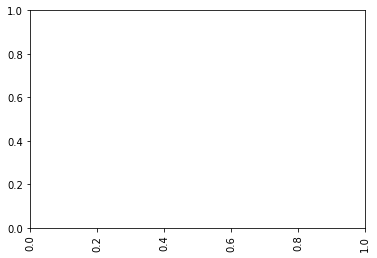

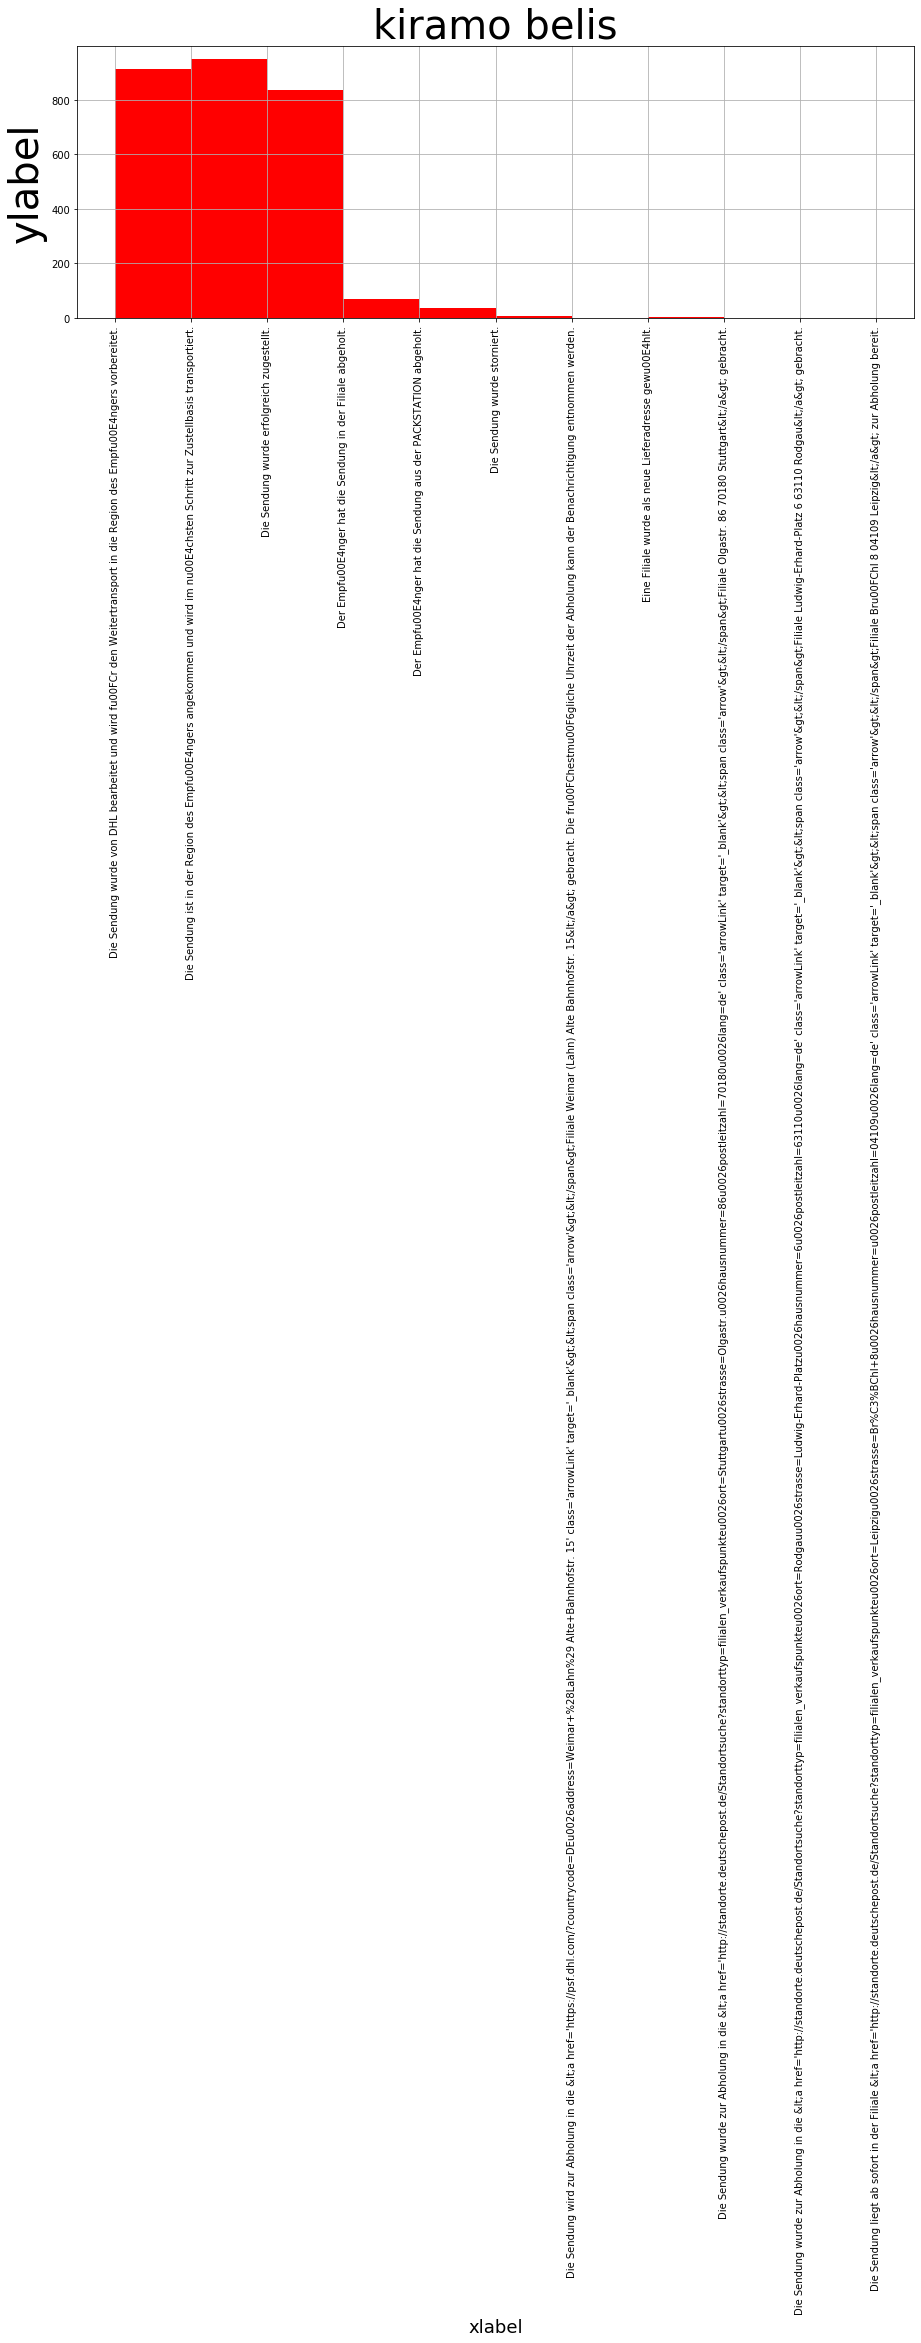

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
fig, ax = plt.subplots()
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=40)
plt.title("kiramo belis", fontsize=40)
plt.xticks(rotation=90)

df[df["status"].isin(final_delivery_states)]["status"].hist(figsize=(15,5), ax=ax, color="red")
fig.savefig('example.png')


### Distribution of initial states

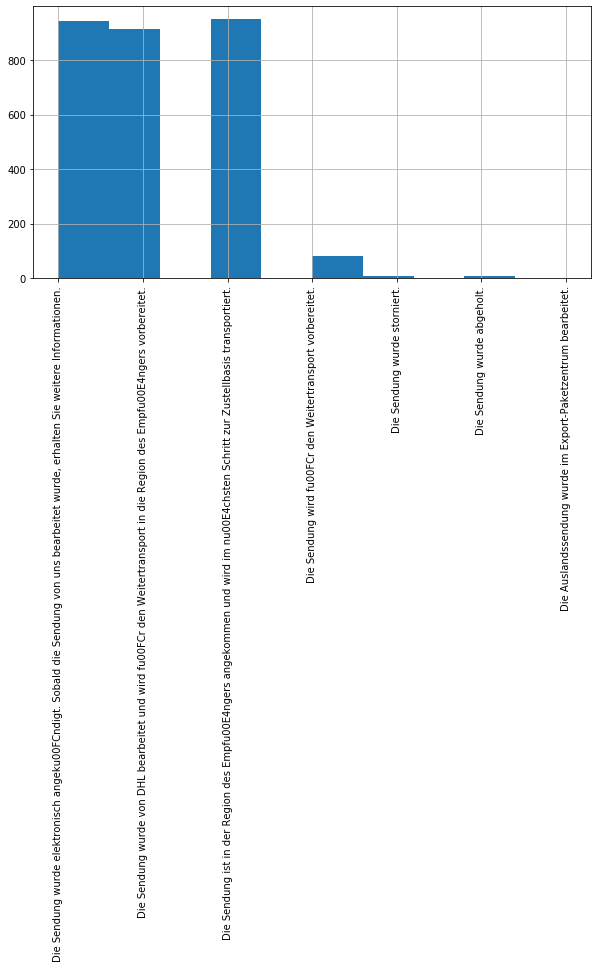

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')

df[df["status"].isin(initial_delivery_states)]["status"].hist(figsize=(10,5))

### Distribution of all states

These are the most common states

In [ ]:
pd.DataFrame(df["status"].value_counts()).head(10)

These are the least common states. What we see here is that there are some states that are basically the same and the following pattern:

"Die Sendung liegt in der ........ zur Abholung bereit"

But the address is each time different. This leads to too many states, which also makes machine learning hard. We ignore the address part and convert all these states to a single one.

In [ ]:
pd.DataFrame(df["status"].value_counts()).tail(10)

In [ ]:
df.loc[(df['status'].str.startswith("Die Sendung liegt in der")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status'].str.endswith("gebracht.")), "status"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status'].str.endswith("wurde gewu00E4hlt.")), "status"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

df.loc[(df['status_next'].str.startswith("Die Sendung liegt in der")) & (df['status_next'].str.endswith("zur Abholung bereit.")), "status_next"] = "Die Sendung liegt in der ... zur Abholung bereit." 
df.loc[(df['status'].str.startswith("Die Sendung liegt ab sofort in der Filiale")) & (df['status'].str.endswith("zur Abholung bereit.")), "status"] = "Die Sendung liegt ab sofort in dert Filiale ... zur Abholung bereit."
df.loc[(df['status_next'].str.startswith("Die Sendung wird zur Abholung in die")) & (df['status_next'].str.endswith("gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich.")), "status_next"] = "Die Sendung wird zur Abholung in die ... gebracht. Fu00FCr die Abholung ist neben der Benachrichtigung die Vorlage Ihres Ausweises sowie ggf. eine Vollmacht erforderlich." 
df.loc[(df['status_next'].str.startswith("Die Sendung wurde zur Abholung in die")) & (df['status_next'].str.endswith("gebracht.")), "status_next"] = "Die Sendung wurde zur Abholung in die ... gebracht." 
df.loc[(df['status_next'].str.startswith("Die Zustellung am gewu00FCnschten Liefertag")) & (df['status_next'].str.endswith("wurde gewu00E4hlt.")), "status_next"] = "Die Zustellung am gewu00FCnschten Liefertag ... wurde gewu00E4hlt." 

In [ ]:
pd.DataFrame(df["status"].value_counts()).head(10)

In [ ]:
pd.DataFrame(df["status"].value_counts()).tail(10)

In [ ]:
len(df["status"].unique())

In [ ]:
len(df["status_next"].unique())

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xticks(rotation='vertical')
df["status"].hist(figsize=(15,5))

We introduces two new states to status_next: SuccessDelivery, FailedDelivery

### Distribution of the locations

In [ ]:
len(df["ort"].unique())

In [ ]:
pd.DataFrame(df["ort"].value_counts()).head(20)

In [ ]:
pd.DataFrame(df["ort"].value_counts()).tail(20)

Notice: One idea here could be to merge some locations. 

### Remove unused columns

In [ ]:
df.drop(columns=["crawltime", "url"], inplace=True)

In [ ]:
df.head()

### Distribution of event times

In [ ]:
counts = df['datum'].dt.dayofweek.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

We see in the above plot which days of the week have the highest amount of events. Sunday has for example the least amount of events, as expected.

In [ ]:
counts = df['datum'].dt.hour.value_counts(sort=False)
plt.bar(counts.index,counts)
plt.show()

In the above plot we see the distribution of the events over 24 hours of a day

### Time diff between events

In [ ]:
df['datum'] = pd.to_datetime(df['datum'], utc=True)
df['datum_next'] = pd.to_datetime(df['datum_next'], utc=True)
df["datum_diff"] = df["datum_next"] - df["datum"]

Notice that for is_final_event=1, the datum_diff does not make any sense. Do not use it in the analysis

In [ ]:
df[df["is_final_event"] == 0]['datum_diff'].astype('timedelta64[h]').plot.hist()

We observe two interesting things here. There are events with zero time diff and there are events with very big time diffs.

### Events with very small time diffs

In [ ]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[s]') == 0)] 

### Events with huge time diffs

In [ ]:
df[(df["is_final_event"] == 0.0) & (df['datum_diff'].astype('timedelta64[h]') > 150)] 

### Distribution of time diff for various states

In [ ]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [ ]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

In [ ]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['status'], layout=(len(df_temp["status"].unique()), 1), figsize=(10,80))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

In [ ]:
df.head()

### Distribution of time diff for various locations

In [ ]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [ ]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

In [ ]:
%matplotlib inline
df_temp["datum_diff_h"].hist(by=df_temp['ort'], layout=(len(df_temp["ort"].unique()), 1), figsize=(10,140))
plt.tight_layout()
df.drop(columns=["datum_diff_h"], inplace=True)

### Distribution of time diff for various locations and states

In [ ]:
df["datum_diff_h"] = df['datum_diff'].astype('timedelta64[h]')

In [ ]:
df_temp = df[df["is_final_event"] == 0][["datum_diff_h", "status", "ort"]]
df_temp.reset_index()
df_temp.index = range(0,df_temp.shape[0])
df_temp.head()

In [ ]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


grouped = df_temp.groupby(["status", "ort"])

for name, group in grouped:
    fig = plt.figure()
    fig.suptitle(str(name) + ": #{}".format(len(group)))
    matplotlib.pyplot.hist(group.datum_diff_h)
    plt.show()
    
df.drop(columns=["datum_diff_h"], inplace=True)

In [ ]:
df.head()